# Project 03: cPyMAD: Particle Tracking Widget
---

<div class="alert alert-block alert-danger">
<b> Note that this is an advanced project best suited for those with python experience </b> 

## Prerequisites
Please complete the courses in ../00_Teaching_Material before attempting this project

- [ ] Introduction to Jupyter Notebooks
- [ ] Introduction to PyParticleBunch
- [ ] Introduction to Plotting with MatPlotLib

### Optional
- [ ] Introduction to iPython widgets

---
# Suggested Approach to Projects:

<div class="alert alert-block alert-success">
<b>Step 1 (Easy)</b> Prototype your code: play with python until it does what you want it to do!
</div>

<div class="alert alert-block alert-warning">
<b>Step 2 (Moderate):</b> Functions: convert your working messy code into nice clean functions, remember to think carefully about function and variable names, inputs to the function (arguments), and what it outputs.
</div>

<div class="alert alert-block alert-danger">
<b>Step 3 (Advanced) </b> Widget: try to use iPython widgets to turn your functions into a GUI (graphical user interface)
</div>

# Project Goal:

To produce a widget that generates a simple PyParticleBunch, and tracks it around the ISIS synchrotron. Tracking can be either turn-by-turn (bunch recorded once per turn), or element-by-element (bunch recorded once per element).

Things to consider:
- cPyMAD will read the input bunch file, track it as requested, and store the output in an internal MAD-X table called `trackone`. Functions are provided for proper handling of this data.
- plotting examples are provided, but you will need to put these into functions and decide how to pass the appropriate data to these functions
- the example code provides all required cpymad functionality. You are not expected to learn cpymad as this would take more than a week. Please request help with any cpymad error if you cannot solve it within 5 minutes.

---
# Example Code

- [ ] Choose MAD-X or PTC tracking
- [x] Load lattice function (thin lens for MAD tracking)
- [x] Generate Bunch function (dump correct file tpye MAD/PTC)
- [x] Track element-by-element function
- [x] Read element-by-element trackone table function
- [x] Plot element-by-element tracking
- [ ] Generate Poincare Bunch function (dump correct file tpye MAD/PTC)
- [x] Track turn-by-turn function
- [ ] Read turn-by-turn trackone table function
- [ ] Plot Poincare Section

In [1]:
%run cpymad_helpers.py

In [2]:
%run helper_functions.py

#### Function to start cpymad, load ISIS lattice

In [3]:
def cpymad_start_ISIS(lattice_folder, save_folder, sequence_name='synchrotron', thin_lens=False, logfile='cpymad_logfile.log'):
    
    make_directory(save_folder)
    if '/' in save_folder:
        cpymad_logfile = save_folder + logfile
    else:
        cpymad_logfile = save_folder + '/' + logfile
        
    
    madx = cpymad_start(cpymad_logfile)
    madx.call(file=lattice_folder+'ISIS.injected_beam')
    #madx.call(file=lattice_folder+'ISIS.extracted_beam')
    madx.call(file=lattice_folder+'ISIS.elements')
    madx.call(file=lattice_folder+'ISIS.strength')
    madx.call(file=lattice_folder+'ISIS.sequence')    
    
    if thin_lens:
        cpymad_check_and_use_sequence(madx, cpymad_logfile, sequence_name)
        madx_command='select, flag=makethin, clear;'
        madx.input(madx_command)
        madx_command='select, flag=makethin, class=quadrupole, slice=4;'
        madx.input(madx_command)
        madx_command='select, flag=makethin, class=sextupole, slice=1;'
        madx.input(madx_command)
        madx_command='select, flag=makethin, class=sbend, slice=4, thick=true;'
        madx.input(madx_command)
        madx_command='makethin, sequence='+sequence_name+', style=teapot, makedipedge=false;'
        madx.input(madx_command)
        
    return madx

#### Function to get initial bunch parameters from TWISS

In [4]:
def get_initial_bunch_twiss_from_cpymad_twiss(madx_twiss):    
    parameters = dict()
    
    parameters['beta_x'] = madx_twiss.betx[0]
    parameters['alpha_x'] = madx_twiss.alfx[0]
    parameters['beta_y'] = madx_twiss.bety[0]
    parameters['alpha_y'] = madx_twiss.alfy[0]
    parameters['d_x'] = madx_twiss.dx[0]
    parameters['d_xp'] = madx_twiss.dpx[0]
    parameters['d_y'] = madx_twiss.dy[0]
    parameters['d_yp'] = madx_twiss.dpy[0]
    parameters['x'] = madx_twiss.x[0]
    parameters['px'] = madx_twiss.px[0]
    parameters['y'] = madx_twiss.y[0]
    parameters['py'] = madx_twiss.py[0]    
    
    return parameters 

#### Function to generate simple matched bunch

In [5]:
from PyParticleBunch import *
def generate_matched_gaussian_particlebunch(madx_instance, cpymad_logfile, save_folder, n_particles, emittance, bunch_filename, thin_lens, sequence_name='synchrotron'):
    
    # TWISS generates the lattice parameters
    twiss_0 = cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, str(save_folder+'twiss_0.tfs'))
    
    # Function takes the initial parameters for the bunch
    bunch_params = get_initial_bunch_twiss_from_cpymad_twiss(twiss_0)

    # Generate matched Gaussian 4D
    Matched_Gaussian_4D_bunch = ParticleBunch.MatchedGaussian_4D(n_particles, emittance, emittance, bunch_params['alpha_x'], bunch_params['beta_x'], bunch_params['alpha_y'], bunch_params['beta_y'], x_limit = 5, y_limit = 5)

    # Dump to required file
    if thin_lens:
        Matched_Gaussian_4D_bunch.print_MADX_file(bunch_filename)
    else:        
        Matched_Gaussian_4D_bunch.print_PTC_file(bunch_filename)

#### Function to generate simple matched bunch

In [6]:
from PyParticleBunch import *
def generate_matched_poincare_particlebunch(madx_instance, cpymad_logfile, save_folder, n_particles, emittance, bunch_filename, thin_lens, sequence_name='synchrotron'):
    
    # TWISS generates the lattice parameters
    twiss_0 = cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, str(save_folder+'twiss_0.tfs'))
    
    # Function takes the initial parameters for the bunch
    bunch_params = get_initial_bunch_twiss_from_cpymad_twiss(twiss_0)

    # Generate matched Poincare 4D
    Matched_Poincare_1D_bunch = ParticleBunch.Poincare_1D(n_particles, 'x', emittance, bunch_params['alpha_x'], bunch_params['beta_x'], min_sig=0, max_sig=10)
    
    # Dump to required file
    if thin_lens:
        Matched_Poincare_1D_bunch.print_MADX_file(bunch_filename)
    else:        
        Matched_Poincare_1D_bunch.print_PTC_file(bunch_filename)

#### Function to list every element in the lattice

In [7]:
def observation_list_from_file(twiss_file):
    madx_twiss_file = tfs.read(twiss_file)
    element_names = madx_twiss_file.NAME
    
    observation_list = []    
    for element in element_names:
        observation_list.append(str(element))
        
    observation_list = [x.lower() for x in observation_list]
    
    return observation_list

#### Function to thin lens track

In [8]:
def cpymad_track_bunchfile(madx_instance, cpymad_logfile, sequence_name, bunch_file, turns, observation_list, losses=False):
    madx_instance.use(sequence=sequence_name)   
    
    if losses:
        madx_command='TRACK, ONETABLE=TRUE, DUMP=TRUE, RECLOSS=TRUE;'  
    else:
        madx_command='TRACK, ONETABLE=TRUE, DUMP=TRUE;'    
    madx_instance.input(madx_command)

    for element in observation_list:
        madx_command = 'OBSERVE, PLACE='+str(element)+';'
        madx_instance.input(madx_command)
    
    if not check_if_file_exists(bunch_file): 
        print('cpymad_track_bunchfile:: check_if_file_exists returns FALSE. Aborting')
        return False
    
    madx_instance.call(file=bunch_file)
    
    if losses:
        madx_command ='RUN, TURNS='+str(int(turns))+', maxaper={0.1, 0.01, 0.1, 0.01, 1.0, 0.1};'        
    else:
        madx_command ='RUN, TURNS='+str(int(turns))+';'
    madx_instance.input(madx_command)

    madx_instance.input('ENDTRACK;')
    return True

#### Function to thick lens track element-by-element

In [9]:
def cpymad_ptc_track_element_by_element(madx_instance, cpymad_logfile, sequence_name, bunch_file, turns, observation_list, lossfiles=False):
    madx_instance.use(sequence=sequence_name)   
    
    madx_instance.input('ptc_create_universe;')
    madx_instance.input('ptc_create_layout,model=2,method=2,nst=1,exact,time=true;')
    
    if not check_if_file_exists(bunch_file): 
        print('cpymad_ptc_track_bunchfile:: check_if_file_exists returns FALSE. Aborting')
        return False    
    madx_instance.call(file=bunch_file)

    for element in observation_list:
        madx_command = 'PTC_OBSERVE, PLACE='+str(element)+';'
        madx_instance.input(madx_command)
    
    if lossfiles:
        madx_command='ptc_track, turns='+str(int(turns))+', element_by_element, closed_orbit, onetable, icase=4, dump=true, recloss=true, maxaper={1.0, 0.1, 1.0, 0.1, 1000.0, 1.0};'  
    else:
        #madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=5, dump=true;'    
        # Note deltap is used for icase=5 only
        #madx_command='ptc_track, deltap=0.01, turns='+str(int(turns))+', closed_orbit, onetable, icase=5, dump=true, norm_no=1, maxaper={1000, 1000, 1000, 1000, 1000, 1000};'    
        madx_command='ptc_track, turns='+str(int(turns))+', element_by_element, closed_orbit, onetable, icase=5, dump=true, norm_no=1, maxaper={1000, 1000, 1000, 1000, 1000, 1000};'    
    madx_instance.input(madx_command)

    madx_instance.input('ptc_track_end;')
    madx_instance.input('ptc_end;')
    return True

#### Function to track thick lens turn-by-turn

In [10]:
def cpymad_ptc_track_bunchfile(madx_instance, cpymad_logfile, sequence_name, bunch_file, turns, observation_list, lossfiles=False):
    madx_instance.use(sequence=sequence_name)   
    
    madx_instance.input('ptc_create_universe;')
    madx_instance.input('ptc_create_layout,model=2,method=2,nst=1,exact,time=true;')
    
    if not check_if_file_exists(bunch_file): 
        print('cpymad_ptc_track_bunchfile:: check_if_file_exists returns FALSE. Aborting')
        return False    
    madx_instance.call(file=bunch_file)

    for element in observation_list:
        madx_command = 'ptc_observe, place='+str(element)+';'
        madx_instance.input(madx_command)
    
    if lossfiles:
        madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=4, dump=true, recloss=true, maxaper={1.0, 0.1, 1.0, 0.1, 1000.0, 1.0};'  
    else:
        #madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=5, dump=true;'    
        # Note deltap is used for icase=5 only
        #madx_command='ptc_track, deltap=0.01, turns='+str(int(turns))+', closed_orbit, onetable, icase=5, dump=true, norm_no=1, maxaper={1000, 1000, 1000, 1000, 1000, 1000};'    
        madx_command='ptc_track, turns='+str(int(turns))+', closed_orbit, onetable, icase=5, dump=true, norm_no=1, maxaper={1000, 1000, 1000, 1000, 1000, 1000};'    
    madx_instance.input(madx_command)

    madx_instance.input('ptc_track_end;')
    madx_instance.input('ptc_end;')
    return True

#### Function to convert MAD-X output into a pandas dataframe (element-by-element thin lens tracking)

In [11]:
def cpymad_tracktable_to_dframe_element_by_element(madx_instance, cpymad_logfile, sequence_name, tracked_file, observation_element):
    if not check_if_file_exists(tracked_file):
        print('cpymad_tracktable_to_dframe_element_by_element::ERROR: Input file not found')
        return False
    
    # empty dataframe with column names and expected types
    df = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int','Element': 'str', 'turn': 'int', 's': 'float', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 'e': 'float'}.items()})
    df_final = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int','Element': 'str', 'turn': 'int', 's': 'float', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 'e': 'float'}.items()})
    
    infile = open(tracked_file)
    linelist = infile.readlines()
    file_len = len(linelist)  
    turn_counter = 0
    last_element = ''
    
    for i in range(0,file_len,1):
        line = linelist[i]
        if line.startswith('@'): pass
        elif line.startswith('*'): pass
        elif line.startswith('$'): pass
        elif line.startswith('#segment'): 
            last_element = str(line.split()[5])
            if observation_element in line:        
                turn_counter +=1
        else:               
            new_row = {'ID': int(float(line.split()[0])), 'Element': last_element, 'turn': int(float(line.split()[1])), 's': (float(line.split()[8])), 'x': (float(line.split()[2])), 'px': (float(line.split()[3])), 'y': (float(line.split()[4])), 'py': (float(line.split()[5])), 't': (float(line.split()[6])), 'pt': (float(line.split()[7])), 'e': (float(line.split()[9]))}
            df_final = df_final.append(new_row, ignore_index=True) 

            #df[int(float(line.split()[0]))] = [int(float(line.split()[1])), float(line.split()[2]), float(line.split()[3]), float(line.split()[4]), float(line.split()[5]),float(line.split()[6]), float(line.split()[7]), float(line.split()[8]), float(line.split()[9])]
            #pnd.concat([df, df_final])
                
    df_new = df_final[df_final['x'].notna()]
    df_new = df_new[df_new['y'].notna()]
    
    twiss_1 = cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, None)
    bunch_params = get_initial_bunch_twiss_from_cpymad_twiss(twiss_1)
    df_new['x_norm'] = df_new.x/np.sqrt(bunch_params['beta_x'])
    df_new['px_norm'] = ((df_new.x*bunch_params['alpha_x'])/np.sqrt(bunch_params['beta_x'])) + np.sqrt(bunch_params['beta_x'])*df_new.px
    df_new['y_norm'] = df_new.y/np.sqrt(bunch_params['beta_y'])
    df_new['py_norm'] = ((df_new.y*bunch_params['alpha_y'])/np.sqrt(bunch_params['beta_y'])) + np.sqrt(bunch_params['beta_y'])*df_new.py
    
    return df_new      
    

#### Function to convert MAD-X output into a pandas dataframe (element-by-element thick lens tracking)

In [12]:
def cpymad_ptc_tracktable_to_dframe_element_by_element(madx_instance, cpymad_logfile, sequence_name, tracked_file, start_element, end_element):
    if not check_if_file_exists(tracked_file):
        print('cpymad_ptc_tracktable_to_dframe_element_by_element::ERROR: Input file not found')
        return False
    
    # empty dataframe with column names and expected types
    df = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int','Element': 'str', 'turn': 'int', 's': 'float', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 'e': 'float'}.items()})
    df_final = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int','Element': 'str', 'turn': 'int', 's': 'float', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 'e': 'float'}.items()})
    
    infile = open(tracked_file)
    linelist = infile.readlines()
    file_len = len(linelist)  
    turn_counter = -1
    last_element = ''
    
    for i in range(0,file_len,1):
        line = linelist[i]
        if line.startswith('@'): pass
        elif line.startswith('*'): pass
        elif line.startswith('$'): pass
        elif line.startswith('#segment'): 
            last_element = str(line.split()[5])
            if start_element in line:        
                turn_counter +=1
        else:               
            new_row = {'ID': int(float(line.split()[0])), 'Element': last_element, 'turn': int(float(line.split()[1])), 's': (float(line.split()[8])), 'x': (float(line.split()[2])), 'px': (float(line.split()[3])), 'y': (float(line.split()[4])), 'py': (float(line.split()[5])), 't': (float(line.split()[6])), 'pt': (float(line.split()[7])), 'e': (float(line.split()[9]))}
            df_final = df_final.append(new_row, ignore_index=True) 

            #df[int(float(line.split()[0]))] = [int(float(line.split()[1])), float(line.split()[2]), float(line.split()[3]), float(line.split()[4]), float(line.split()[5]),float(line.split()[6]), float(line.split()[7]), float(line.split()[8]), float(line.split()[9])]
            #pnd.concat([df, df_final])
                
    df_new = df_final[df_final['x'].notna()]
    df_new = df_new[df_new['y'].notna()]
    
    twiss_1 = cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, None)
    bunch_params = get_initial_bunch_twiss_from_cpymad_twiss(twiss_1)
    df_new['x_norm'] = df_new.x/np.sqrt(bunch_params['beta_x'])
    df_new['px_norm'] = ((df_new.x*bunch_params['alpha_x'])/np.sqrt(bunch_params['beta_x'])) + np.sqrt(bunch_params['beta_x'])*df_new.px
    df_new['y_norm'] = df_new.y/np.sqrt(bunch_params['beta_y'])
    df_new['py_norm'] = ((df_new.y*bunch_params['alpha_y'])/np.sqrt(bunch_params['beta_y'])) + np.sqrt(bunch_params['beta_y'])*df_new.py
    
    return df_new         
    

#### Function to convert MAD-X output into a pandas dataframe (turn-by-turn thin lens tracking)

In [13]:
def cpymad_tracktable_to_dframe_multiple_turns(madx_instance, cpymad_logfile, sequence_name, tracked_file, observation_element):
    if not check_if_file_exists(tracked_file):
        print('cpymad_tracktable_to_files::ERROR: Input file not found')
        return False
    
    # empty dataframe with column names and expected types
    df = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int', 'turn': 'int', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 's': 'float', 'e': 'float'}.items()})
    df_final = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int', 'turn': 'int', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 's': 'float', 'e': 'float'}.items()})
    
    infile = open(tracked_file)
    linelist = infile.readlines()
    file_len = len(linelist)  
    turn_counter = 0
    
    for i in range(0,file_len,1):
        line = linelist[i]
        if line.startswith('@'): pass
        elif line.startswith('*'): pass
        elif line.startswith('$'): pass
        elif line.startswith('#segment'): 
            if observation_element in line:        
                turn_counter +=1
                ignore_flag = False
            else:
                ignore_flag = True
        else:
            if ignore_flag: pass
            else:                
                new_row = {'ID': int(float(line.split()[0])), 'turn': int(float(line.split()[1])), 'x': (float(line.split()[2])), 'px': (float(line.split()[3])), 'y': (float(line.split()[4])), 'py': (float(line.split()[5])), 't': (float(line.split()[6])), 'pt': (float(line.split()[7])), 's': (float(line.split()[8])), 'e': (float(line.split()[9]))}
                df_final = df_final.append(new_row, ignore_index=True) 
            
                #df[int(float(line.split()[0]))] = [int(float(line.split()[1])), float(line.split()[2]), float(line.split()[3]), float(line.split()[4]), float(line.split()[5]),float(line.split()[6]), float(line.split()[7]), float(line.split()[8]), float(line.split()[9])]
                #pnd.concat([df, df_final])
                
    df_new = df_final[df_final['x'].notna()]
    df_new = df_new[df_new['y'].notna()]
    
    twiss_1 = cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, None)
    bunch_params = get_initial_bunch_twiss_from_cpymad_twiss(twiss_1)
    df_new['x_norm'] = df_new.x/np.sqrt(bunch_params['beta_x'])
    df_new['px_norm'] = ((df_new.x*bunch_params['alpha_x'])/np.sqrt(bunch_params['beta_x'])) + np.sqrt(bunch_params['beta_x'])*df_new.px
    df_new['y_norm'] = df_new.y/np.sqrt(bunch_params['beta_y'])
    df_new['py_norm'] = ((df_new.y*bunch_params['alpha_y'])/np.sqrt(bunch_params['beta_y'])) + np.sqrt(bunch_params['beta_y'])*df_new.py
    
    return df_new      
    

#### Function to convert MAD-X output into a pandas dataframe (turn-by-turn thick lens tracking)

In [14]:
def cpymad_ptc_tracktable_to_dframe_multiple_turns(madx_instance, cpymad_logfile, sequence_name, tracked_file, start_element, end_element):
    if not check_if_file_exists(tracked_file):
        print('cpymad_tracktable_to_files::ERROR: Input file not found')
        return False
    
    # empty dataframe with column names and expected types
    df = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int', 'turn': 'int', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 's': 'float', 'e': 'float'}.items()})
    df_final = pnd.DataFrame({c: pnd.Series(dtype=t) for c, t in {'ID': 'int', 'turn': 'int', 'x': 'float', 'px': 'float', 'y': 'float', 'py': 'float', 't': 'float', 'pt': 'float', 's': 'float', 'e': 'float'}.items()})
    
    infile = open(tracked_file)
    linelist = infile.readlines()
    file_len = len(linelist)  
    turn_counter = 0
    
    for i in range(0,file_len,1):
        line = linelist[i]
        if line.startswith('@'): pass
        elif line.startswith('*'): pass
        elif line.startswith('$'): pass
        elif line.startswith('#segment'): 
            if (start_element in line) or (end_element in line):        
                turn_counter +=1
                ignore_flag = False
            else:
                ignore_flag = True
        else:
            if ignore_flag: pass
            else:                
                new_row = {'ID': int(float(line.split()[0])), 'turn': int(float(line.split()[1])), 'x': (float(line.split()[2])), 'px': (float(line.split()[3])), 'y': (float(line.split()[4])), 'py': (float(line.split()[5])), 't': (float(line.split()[6])), 'pt': (float(line.split()[7])), 's': (float(line.split()[8])), 'e': (float(line.split()[9]))}
                df_final = df_final.append(new_row, ignore_index=True) 
            
                #df[int(float(line.split()[0]))] = [int(float(line.split()[1])), float(line.split()[2]), float(line.split()[3]), float(line.split()[4]), float(line.split()[5]),float(line.split()[6]), float(line.split()[7]), float(line.split()[8]), float(line.split()[9])]
                #pnd.concat([df, df_final])
                
    df_new = df_final[df_final['x'].notna()]
    df_new = df_new[df_new['y'].notna()]
    
    twiss_1 = cpymad_madx_twiss(madx_instance, cpymad_logfile, sequence_name, None)
    bunch_params = get_initial_bunch_twiss_from_cpymad_twiss(twiss_1)
    df_new['x_norm'] = df_new.x/np.sqrt(bunch_params['beta_x'])
    df_new['px_norm'] = ((df_new.x*bunch_params['alpha_x'])/np.sqrt(bunch_params['beta_x'])) + np.sqrt(bunch_params['beta_x'])*df_new.px
    df_new['y_norm'] = df_new.y/np.sqrt(bunch_params['beta_y'])
    df_new['py_norm'] = ((df_new.y*bunch_params['alpha_y'])/np.sqrt(bunch_params['beta_y'])) + np.sqrt(bunch_params['beta_y'])*df_new.py

    return df_new      

#### Start cpymad simulation 1 and load ISIS lattice

In [15]:
lattice_folder = './ISIS_Lattice/'
save_folder = 'cpymad_output/'
sequence_name='synchrotron'
thin_lens = True
cpymad_logfile = 'cpymad_output/cpymad_logfile.log'

madx_simulation = cpymad_start_ISIS(lattice_folder, save_folder, sequence_name, thin_lens)

Directory cpymad_output/ exists
Sequence synchrotron exists in this instance of MAD-X. Active sequences:
{'synchrotron': <Sequence: synchrotron>}


#### Generate matched bunch

In [16]:
n_particles = 10
emittance = 400 * 1E-6
bunch_filename = 'Gaussian_bunch_10.ptc'

generate_matched_gaussian_particlebunch(madx_simulation, cpymad_logfile, save_folder, n_particles, emittance, bunch_filename, thin_lens, sequence_name)

Sequence synchrotron exists in this instance of MAD-X. Active sequences:
{'synchrotron': <Sequence: synchrotron>}


#### To track element-by-element we must observe at each element

In [17]:
observation_list = observation_list_from_file((save_folder+'twiss_0.tfs'))

In [18]:
observation_list

['synchrotron$start',
 'sp0_datum',
 'sp0_dipfr8',
 'sp0_dipfr9',
 'sp0_dipfr10',
 'drift_0',
 'sp0_r0hd1',
 'drift_1',
 'sp0_r0hm1',
 'drift_2',
 'sp0_r0vm1',
 'drift_3',
 'sp0_r0vd1',
 'drift_4',
 'sp0_qdfr1',
 'sp0_qdfr2',
 'sp0_qdfr3',
 'sp0_qdfr4',
 'sp0_qd',
 'sp0_qdfr5',
 'sp0_qdfr6',
 'sp0_qdfr7',
 'sp0_qdfr8',
 'drift_5',
 'sp0_qtd',
 'drift_6',
 'sp0_qffr1',
 'sp0_qffr2',
 'sp0_qffr3',
 'sp0_qffr4',
 'sp0_qf',
 'sp0_qffr5',
 'sp0_qffr6',
 'sp0_qffr7',
 'sp0_qffr8',
 'drift_7',
 'sp0_qtf',
 'drift_8',
 'sp0_r0hm2',
 'drift_9',
 'sp0_idip1',
 'drift_10',
 'sp0_idip2',
 'drift_11',
 'sp0_foil',
 'drift_12',
 'sp0_idip3',
 'drift_13',
 'sp0_idip4',
 'drift_14',
 'sp0_qdsfr1',
 'sp0_qdsfr2',
 'sp0_qdsfr3',
 'sp0_qdsfr4',
 'sp0_qds',
 'sp0_qdsfr5',
 'sp0_qdsfr6',
 'sp0_qdsfr7',
 'sp0_qdsfr8',
 'drift_15',
 'sp0_dipfr1',
 'sp0_dipfr2',
 'sp0_dipfr3',
 'sp0_dipfr4',
 'sp0_dipfr5',
 'sp0_dip1',
 'sp0_dip2',
 'sp0_dip3',
 'sp0_dip4',
 'sp0_dip5',
 'sp0_dip6',
 'sp0_dipfr6',
 'sp0_dipfr

In [19]:
turns = 1

if thin_lens:
    cpymad_track_bunchfile(madx_simulation, cpymad_logfile, sequence_name, bunch_filename, turns, observation_list, losses=False)
else:
    cpymad_ptc_track_element_by_element(madx_simulation, cpymad_logfile, sequence_name, bunch_filename, turns, observation_list, lossfiles=False)
    

Gaussian_bunch_10.ptc  exists


#### If tracking was successful a trackone table should exist inside MAD-X, this will be dumped to a file called trackone (no extension)

In [20]:
list(madx_simulation.table)

['summ', 'twiss', 'tracksumm', 'trackone']

#### Process the dumped trackone file to generate a pandas dataframe

In [21]:
if thin_lens:
    myParticle = cpymad_tracktable_to_dframe_element_by_element(madx_simulation, cpymad_logfile, sequence_name, 'trackone', observation_list[0])
else:
    myParticle = cpymad_ptc_tracktable_to_dframe_element_by_element(madx_simulation, cpymad_logfile, sequence_name, 'trackone', observation_list[0], observation_list[-1])

trackone  exists
Sequence synchrotron exists in this instance of MAD-X. Active sequences:
{'synchrotron': <Sequence: synchrotron>}


In [22]:
myParticle

,ID,Element,turn,s,x,px,y,py,t,pt,e,x_norm,px_norm,y_norm,py_norm
0,1,start,0,0.00000,0.086530,-0.009219,-0.016559,-0.010470,0.000000,0.0,0.0,0.026718,-0.009837,-0.006801,-0.017921
1,2,start,0,0.00000,0.004046,-0.004995,0.017482,0.010949,0.000000,0.0,0.0,0.001249,-0.015240,0.007180,0.018665
2,3,start,0,0.00000,-0.008915,-0.000795,0.024398,-0.008473,0.000000,0.0,0.0,-0.002753,-0.004636,0.010020,-0.031791
3,4,start,0,0.00000,0.024907,0.001399,0.070296,0.006110,0.000000,0.0,0.0,0.007691,0.010293,0.028870,-0.017273
4,5,start,0,0.00000,-0.044966,0.003219,0.043872,-0.004170,0.000000,0.0,0.0,-0.013884,0.000023,0.018018,-0.030219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,6,synchrotron$end,1,163.36282,-0.011585,-0.001795,-0.017569,-0.005508,0.012335,0.0,0.0,-0.003577,-0.008495,-0.007216,-0.005376
5476,7,synchrotron$end,1,163.36282,-0.071854,0.007354,0.059335,0.012455,0.039198,0.0,0.0,-0.022187,0.007192,0.024369,0.003189
5477,8,synchrotron$end,1,163.36282,0.027251,-0.005028,0.028085,0.018886,-0.087672,0.0,0.0,0.008415,-0.009979,0.011535,0.033140
5478,9,synchrotron$end,1,163.36282,-0.045679,0.002755,0.029945,0.015568,0.017458,0.0,0.0,-0.014104,-0.001646,0.012299,0.024211


#### Plot the tracks of n particles for one turn, where their locations are stored once per element

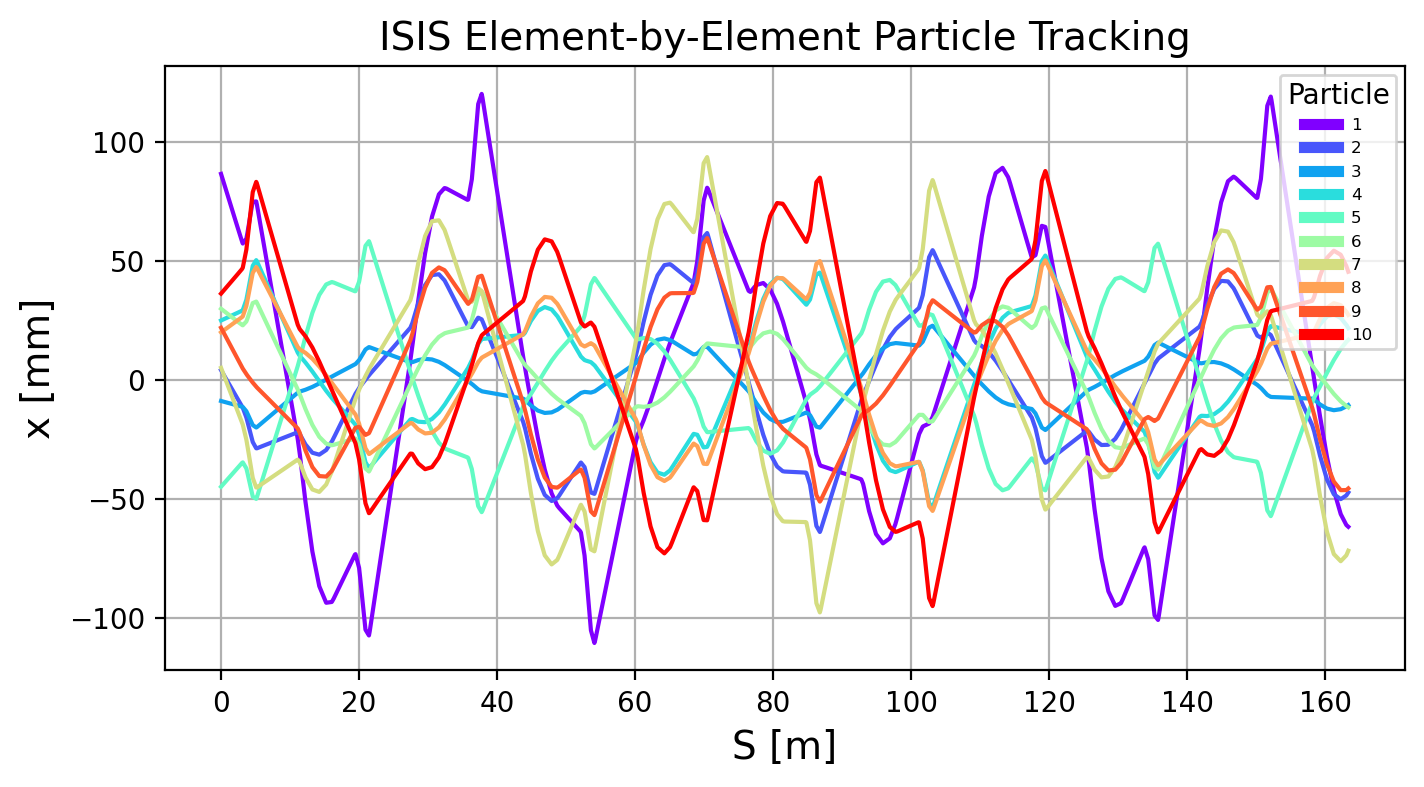

In [23]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k');

plt.title('ISIS Element-by-Element Particle Tracking')
plt.xlabel('S [m]');
plt.ylabel('x [mm]')
#plt.ylim(-.30, .30)
#plt.xlim(0, 30)
plt.grid(which='both');

colours = cm.rainbow(np.linspace(0, 1, n_particles))
custom_labels = []
custom_lines = []

for i in range(n_particles):
    plt.plot(myParticle['s'][(myParticle['ID']==i+1)], myParticle['x'][(myParticle['ID']==i+1)]*1E3, color=colours[i])
    custom_labels.append(str(i+1))
    custom_lines.append(Line2D([0], [0], color=colours[i], lw=4))
    
plt.legend(custom_lines, custom_labels, title='Particle', fontsize=6)
    
if thin_lens: savename = save_folder + 'Element_by_Element_Thin_Lens_Tracking.png'
else:         savename = save_folder + 'Element_by_Element_Thick_Lens_Tracking.png'
plt.savefig(savename)

#### End the cpymad (MAD-X) simulation

In [24]:
madx_simulation.quit()

## cpymad simulation 2: turn-by-turn tracking to produce a Poincare Section

#### Start cpymad simulation 1 and load ISIS lattice

In [25]:
lattice_folder = './ISIS_Lattice/'
save_folder = 'cpymad_output/'
sequence_name='synchrotron'
thin_lens = False
cpymad_logfile = 'cpymad_output/cpymad_logfile2.log'
logfile = 'cpymad_logfile2.log'

madx_simulation2 = cpymad_start_ISIS(lattice_folder, save_folder, sequence_name, thin_lens, logfile)

Directory cpymad_output/ exists


#### Generate matched bunch

In [26]:
n_particles = 11
emittance = 400 * 1E-6
bunch_filename = 'Poincare_bunch_10.ptc'

generate_matched_poincare_particlebunch(madx_simulation2, cpymad_logfile, save_folder, n_particles, emittance, bunch_filename, thin_lens, sequence_name='synchrotron')

Sequence synchrotron exists in this instance of MAD-X. Active sequences:
{'synchrotron': <Sequence: synchrotron>}
x
MatchedBunchGenerator1D::Poincare_1D: Dispersion Not Set - Assuming to be ZERO


#### To track element-by-element we must observe at each element

In [27]:
full_observation_list = observation_list_from_file((save_folder+'twiss_0.tfs'))

In [28]:
observation_list = []

In [29]:
turns = 1024

if thin_lens:
    cpymad_track_bunchfile(madx_simulation2, cpymad_logfile, sequence_name, bunch_filename, turns, observation_list, losses=False)
else:
    cpymad_ptc_track_bunchfile(madx_simulation2, cpymad_logfile, sequence_name, bunch_filename, turns, observation_list, lossfiles=False)

Poincare_bunch_10.ptc  exists


#### If tracking was successful a trackone table should exist inside MAD-X, this will be dumped to a file called trackone (no extension)

In [30]:
list(madx_simulation2.table)

['summ',
 'twiss',
 'errors_dipole',
 'errors_field',
 'errors_total',
 'tracksumm',
 'trackone']

#### Process the dumped trackone file to generate a pandas dataframe

In [31]:
if thin_lens:
    myParticle2 = cpymad_tracktable_to_dframe_multiple_turns(madx_simulation2, cpymad_logfile, sequence_name, 'trackone', full_observation_list[-1])
else:
    myParticle2 = cpymad_ptc_tracktable_to_dframe_multiple_turns(madx_simulation2, cpymad_logfile, sequence_name, 'trackone', 'start', 'end')

trackone  exists
Sequence synchrotron exists in this instance of MAD-X. Active sequences:
{'synchrotron': <Sequence: synchrotron>}


In [32]:
myParticle2

,ID,turn,x,px,y,py,t,pt,s,e,x_norm,px_norm,y_norm,py_norm
0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,1.008712,0.000000,0.000000,0.0,0.0
1,2.0,0.0,0.064772,0.000000,0.0,0.0,0.0,0.0,0.00000,1.008712,0.020000,0.014986,0.0,0.0
2,3.0,0.0,0.129544,0.000000,0.0,0.0,0.0,0.0,0.00000,1.008712,0.040000,0.029973,0.0,0.0
3,4.0,0.0,0.194316,0.000000,0.0,0.0,0.0,0.0,0.00000,1.008712,0.060000,0.044959,0.0,0.0
4,5.0,0.0,0.259088,0.000000,0.0,0.0,0.0,0.0,0.00000,1.008712,0.080000,0.059946,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11270,7.0,1024.0,-0.307131,-0.016771,0.0,0.0,0.0,0.0,163.36282,1.008712,-0.094834,-0.125376,0.0,0.0
11271,8.0,1024.0,0.338088,0.020580,0.0,0.0,0.0,0.0,163.36282,1.008712,0.104393,0.144873,0.0,0.0
11272,9.0,1024.0,-0.704446,0.044161,0.0,0.0,0.0,0.0,163.36282,1.008712,-0.217516,-0.019970,0.0,0.0
11273,10.0,1024.0,0.013913,-0.072660,0.0,0.0,0.0,0.0,163.36282,1.008712,0.004296,-0.232098,0.0,0.0


#### Plot the tracks of n particles for one turn, where their locations are stored once per element

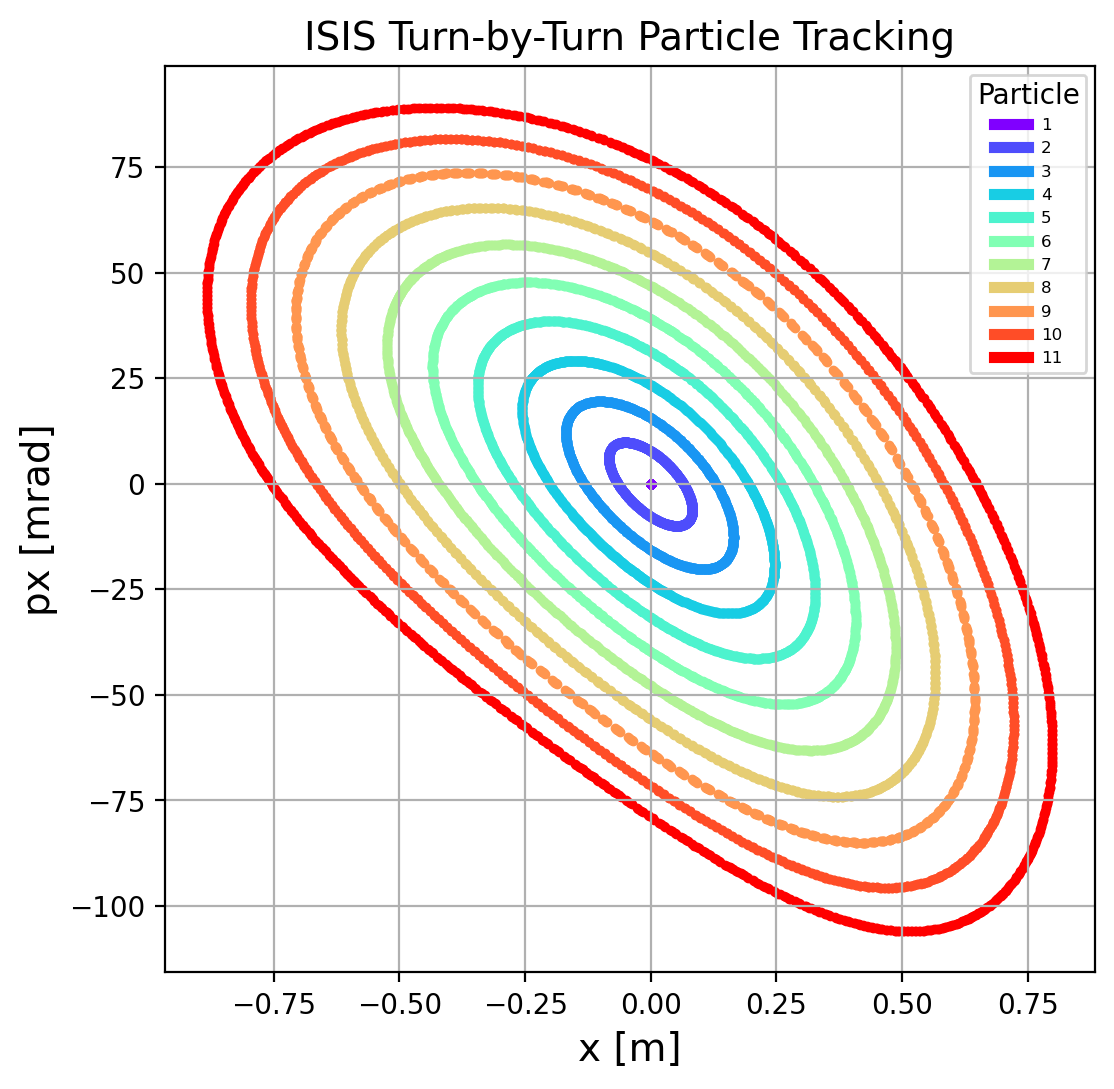

In [33]:
fig=plt.figure(figsize=(6, 6), dpi= 200, facecolor='w', edgecolor='k');

plt.title('ISIS Turn-by-Turn Particle Tracking')
plt.xlabel('x [m]');
plt.ylabel('px [mrad]')
#plt.ylim(-.30, .30)
#plt.xlim(0, 30)
plt.grid(which='both');

colours = cm.rainbow(np.linspace(0, 1, n_particles))
custom_labels = []
custom_lines = []

for i in range(n_particles):
    plt.scatter(myParticle2['x'][(myParticle2['ID']==i+1)], myParticle2['px'][(myParticle2['ID']==i+1)]*1E3, color=colours[i], marker='.')
    custom_labels.append(str(i+1))
    custom_lines.append(Line2D([0], [0], color=colours[i], lw=4))
    
plt.legend(custom_lines, custom_labels, title='Particle', fontsize=6)
if thin_lens: savename = save_folder + 'Turn_by_Turn_Thin_Lens_Tracking.png'
else:         savename = save_folder + 'Turn_by_Turn_Thick_Lens_Tracking.png'
plt.savefig(savename)

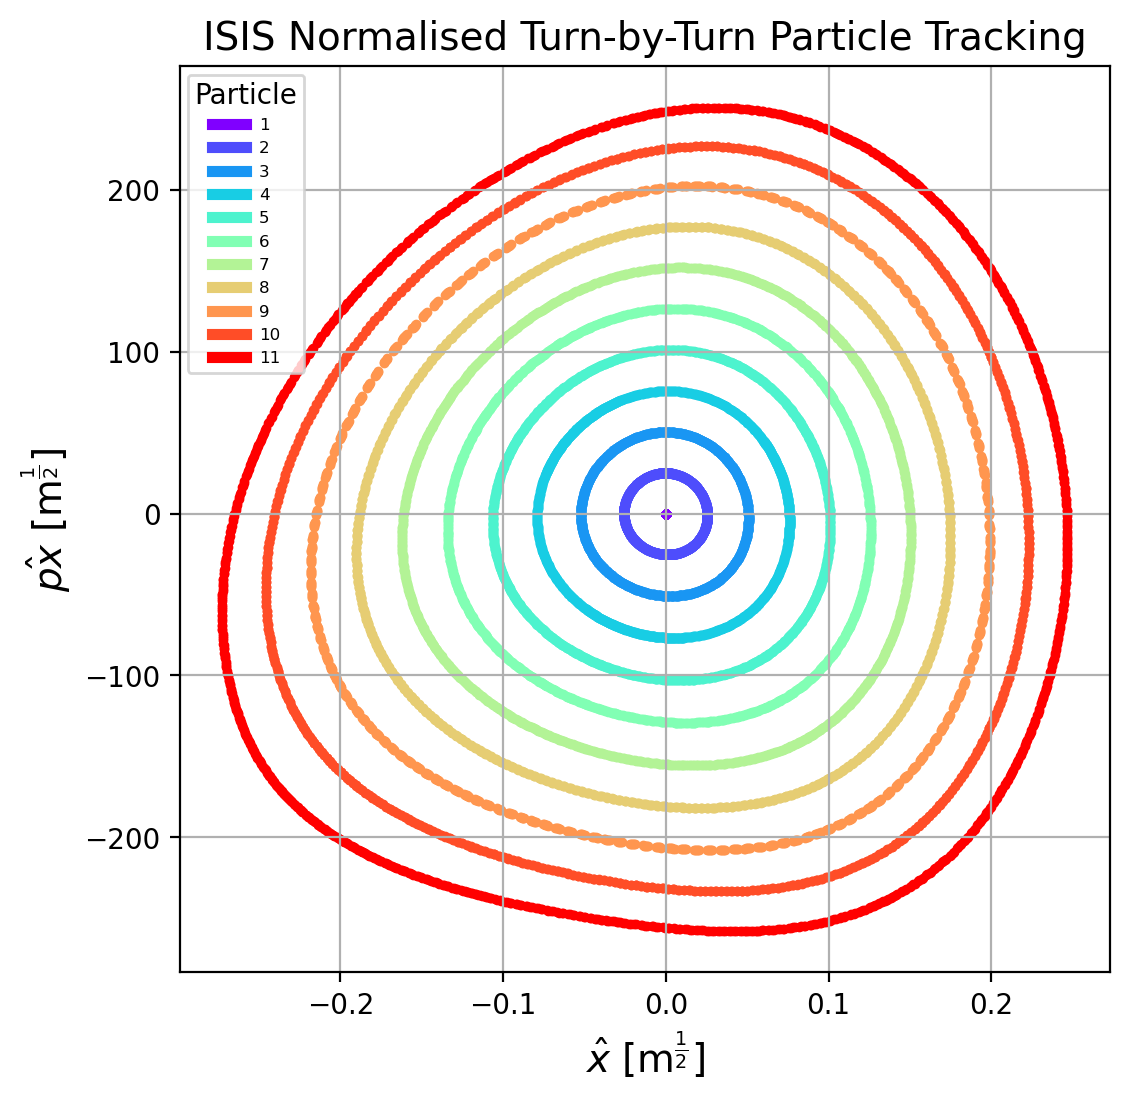

In [34]:
fig=plt.figure(figsize=(6, 6), dpi= 200, facecolor='w', edgecolor='k');

plt.title('ISIS Normalised Turn-by-Turn Particle Tracking')
plt.xlabel(r'$\^{x}$ [m$^{\frac{1}{2}}$]');
plt.ylabel(r'$\^{px}$ [m$^{\frac{1}{2}}$]')
#plt.ylim(-.30, .30)
#plt.xlim(0, 30)
plt.grid(which='both');

colours = cm.rainbow(np.linspace(0, 1, n_particles))
custom_labels = []
custom_lines = []

for i in range(n_particles):
    plt.scatter(myParticle2['x_norm'][(myParticle2['ID']==i+1)], myParticle2['px_norm'][(myParticle2['ID']==i+1)]*1E3, color=colours[i], marker='.')
    custom_labels.append(str(i+1))
    custom_lines.append(Line2D([0], [0], color=colours[i], lw=4))
    
plt.legend(custom_lines, custom_labels, title='Particle', fontsize=6)
if thin_lens: savename = save_folder + 'Turn_by_Turn_Thin_Lens_Tracking_Normalised.png'
else:         savename = save_folder + 'Turn_by_Turn_Thick_Lens_Tracking_Normalised.png'
plt.savefig(savename)

#### End the cpymad (MAD-X) simulation

In [35]:
madx_simulation2.quit()

---
# Your turn

Can you try to create an iPython widget, using the provided functions, that does the following?

## Functionality Required (try adding one thing at a time)

- [ ] Start the cpymad simulation with either thick or thin lens optics
- [ ] Select and generate a simple Gaussian or Poincare initial particle distribution of m particls (user selects m)
- [ ] Select and perform the previously selected thick/thin lens tracking for n turns (user selects n)
- [ ] Process the generated trackone table and:
    - [ ] Plot a Poincare section for turn-by-turn tracking
    - [ ] Plot a normalised Poincare section for turn-by-turn tracking
    - [ ] Plot particle tracks for element-by-element tracking
- [ ] Add plot title
- [ ] Add plot legend and grid
- [ ] Save plot to file (user specificies filename)

### Bonus Tasks
- [ ] Modify the generate_matched_poincare_particlebunch function so the user can select and generate either a horizontal or vertical poincare bunch
- [ ] Add functionality to plot tracks and poincare sections in the vertical plane (co-ordinates y and py)
- [ ] Add functionality to run 2 simulations side-by-side (I can provide a second lattice) in order to plot comparison tracks / Poincare sections
- [ ] Add functionality to plot Poincare sections at a selected element (I suggest using a slider/dropdown widget for the element name or S position in the trackone dataframe to do the selection). This requires:
    - [ ] element-by-element tracking for n turns (where 1024 > n > 1E6)
    - [ ] a new function to plot the poincare section based on selected particle and element name/s position
